In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [81]:
train_data_path = '../data/raw/training_set_VU_DM.csv'
list_of_chunks = []
for chunk in pd.read_csv(train_data_path, chunksize=100000):
    chunk["search_month"] = pd.to_datetime(chunk["date_time"]).dt.month
    modified_chunk = chunk.drop(columns=["date_time","gross_bookings_usd"])
    list_of_chunks.append(modified_chunk)
df = pd.concat(list_of_chunks, ignore_index=True)
print(df.shape)
print(df.info())





(4958347, 53)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4958347 entries, 0 to 4958346
Data columns (total 53 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   srch_id                      int64  
 1   site_id                      int64  
 2   visitor_location_country_id  int64  
 3   visitor_hist_starrating      float64
 4   visitor_hist_adr_usd         float64
 5   prop_country_id              int64  
 6   prop_id                      int64  
 7   prop_starrating              int64  
 8   prop_review_score            float64
 9   prop_brand_bool              int64  
 10  prop_location_score1         float64
 11  prop_location_score2         float64
 12  prop_log_historical_price    float64
 13  position                     int64  
 14  price_usd                    float64
 15  promotion_flag               int64  
 16  srch_destination_id          int64  
 17  srch_length_of_stay          int64  
 18  srch_booking_window         

In [82]:
print("--- Comprehensive Data Overview ---")

# Initialize a list to store dictionaries, where each dictionary is a row in our summary table
summary_list = []

for col in df.columns:
    col_summary = {
        'Feature': col,
        'Data Type': df[col].dtype,
        'Non-Null Count': df[col].count(),
        'Missing Count': df[col].isnull().sum(),
        'Missing (%)': f"{df[col].isnull().mean() * 100:.2f}%",
        'Unique Values': df[col].nunique()
    }
    
    # Add numerical specific stats if the column is numeric
    if pd.api.types.is_numeric_dtype(df[col]):
        col_summary['Mean'] = f"{df[col].mean():.2f}"
        col_summary['Median'] = f"{df[col].median():.2f}"
        col_summary['Std Dev'] = f"{df[col].std():.2f}"
        col_summary['Min'] = f"{df[col].min():.2f}"
        col_summary['25%'] = f"{df[col].quantile(0.25):.2f}"
        col_summary['75%'] = f"{df[col].quantile(0.75):.2f}"
        col_summary['Max'] = f"{df[col].max():.2f}"
    else: # For non-numeric, you might want top value and its frequency
        col_summary['Top Value'] = df[col].mode()[0] if not df[col].mode().empty else 'N/A'
        col_summary['Top Freq'] = df[col].value_counts().iloc[0] if not df[col].value_counts().empty else 'N/A'
        
    summary_list.append(col_summary)

# Convert the list of dictionaries to a DataFrame
df_summary = pd.DataFrame(summary_list)



print(df_summary)

--- Comprehensive Data Overview ---
                        Feature Data Type  Non-Null Count  Missing Count  \
0                       srch_id     int64         4958347              0   
1                       site_id     int64         4958347              0   
2   visitor_location_country_id     int64         4958347              0   
3       visitor_hist_starrating   float64          251866        4706481   
4          visitor_hist_adr_usd   float64          252988        4705359   
5               prop_country_id     int64         4958347              0   
6                       prop_id     int64         4958347              0   
7               prop_starrating     int64         4958347              0   
8             prop_review_score   float64         4950983           7364   
9               prop_brand_bool     int64         4958347              0   
10         prop_location_score1   float64         4958347              0   
11         prop_location_score2   float64         38

In [83]:
# print(df.isna().sum())
missing_percentages = df.isna().sum()/len(df)*100
missing_percentages_sorted = missing_percentages[missing_percentages > 0].sort_values(ascending=False)
print(missing_percentages_sorted)


comp1_rate_percent_diff      98.095353
comp6_rate_percent_diff      98.060362
comp1_rate                   97.581250
comp1_inv                    97.387053
comp4_rate_percent_diff      97.356256
comp7_rate_percent_diff      97.206428
comp6_rate                   95.156511
visitor_hist_starrating      94.920364
visitor_hist_adr_usd         94.897735
comp6_inv                    94.736633
comp4_rate                   93.800797
comp7_rate                   93.640058
srch_query_affinity_score    93.598552
comp4_inv                    93.069001
comp7_inv                    92.811677
comp3_rate_percent_diff      90.464625
comp2_rate_percent_diff      88.781786
comp8_rate_percent_diff      87.602118
comp5_rate_percent_diff      83.036706
comp3_rate                   69.056462
comp3_inv                    66.702814
comp8_rate                   61.344900
comp8_inv                    59.916016
comp2_rate                   59.166392
comp2_inv                    57.036710
comp5_rate               

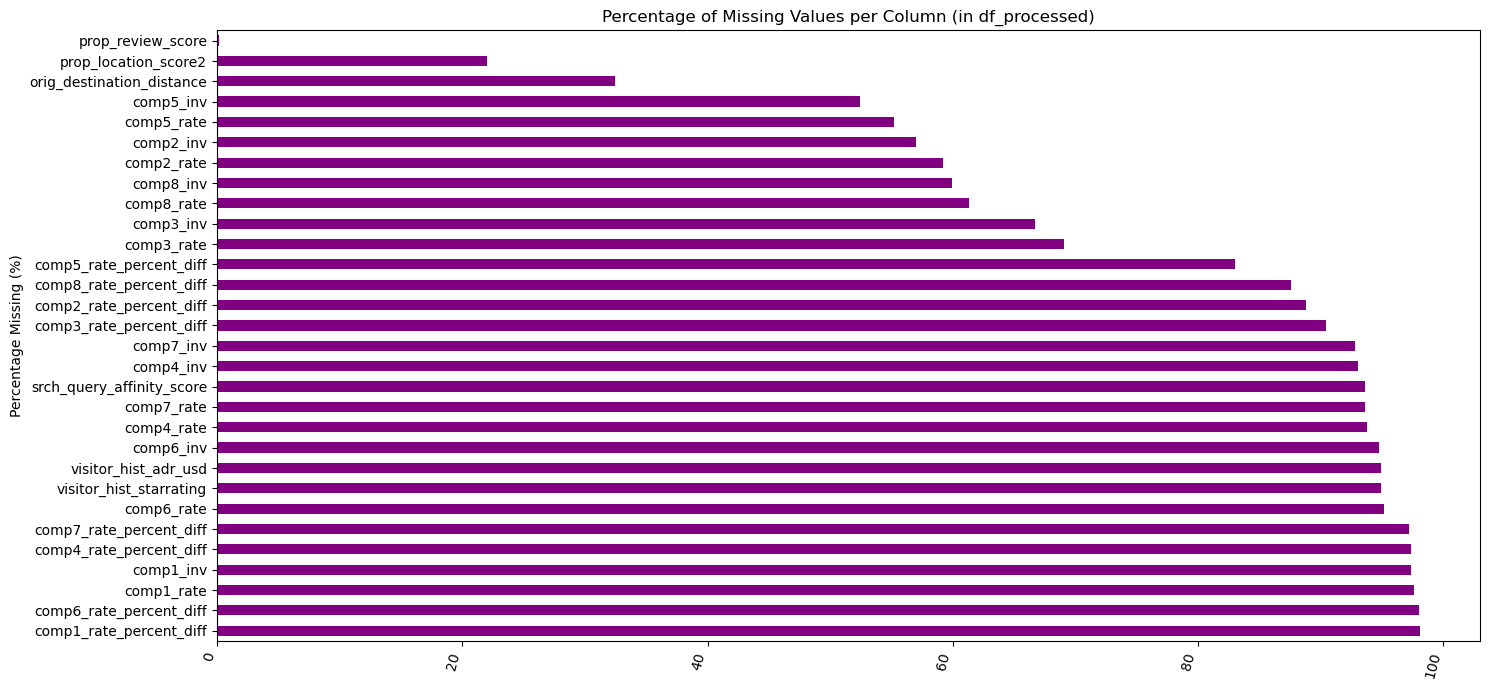

In [84]:
if not missing_percentages_sorted.empty:
        plt.figure(figsize=(15, 7))
        missing_percentages_sorted.plot(kind='barh', color='purple')
        plt.title('Percentage of Missing Values per Column (in df_processed)')
        plt.ylabel('Percentage Missing (%)')
        plt.xticks(rotation=75, ha='right')
        plt.tight_layout() # Adjust layout to make room for labels
        plt.show()

2521485     963.37
3158855     328.89
4175929        NaN
3521798        NaN
3915287      71.01
3216375      69.74
1089300        NaN
1886850    1497.15
1032222     224.66
2427139        NaN
4039079     305.06
3481036        NaN
41340          NaN
2602569    3497.18
1606028        NaN
3846969     205.88
3820053        NaN
3017644     443.76
4173055        NaN
1338520    8596.03
1322102     247.17
1935582     178.78
3137573     202.56
1426270        NaN
2647348     268.61
500141      155.52
4154658     537.33
2057951    2666.55
3027776     326.48
3399762    2708.56
3261353      63.40
3419927     536.44
1903921        NaN
3454603     125.56
4607199     346.20
4474422        NaN
3871139        NaN
2145948    2140.10
399542         NaN
3212348     399.54
4070298     100.05
627251       40.16
3144567     163.96
4567271     394.64
1246967    5927.28
2332791     616.03
4255160    1057.03
2478013      19.80
1312798      13.18
3839268        NaN
Name: orig_destination_distance, dtype: float64


<Axes: xlabel='orig_destination_distance'>

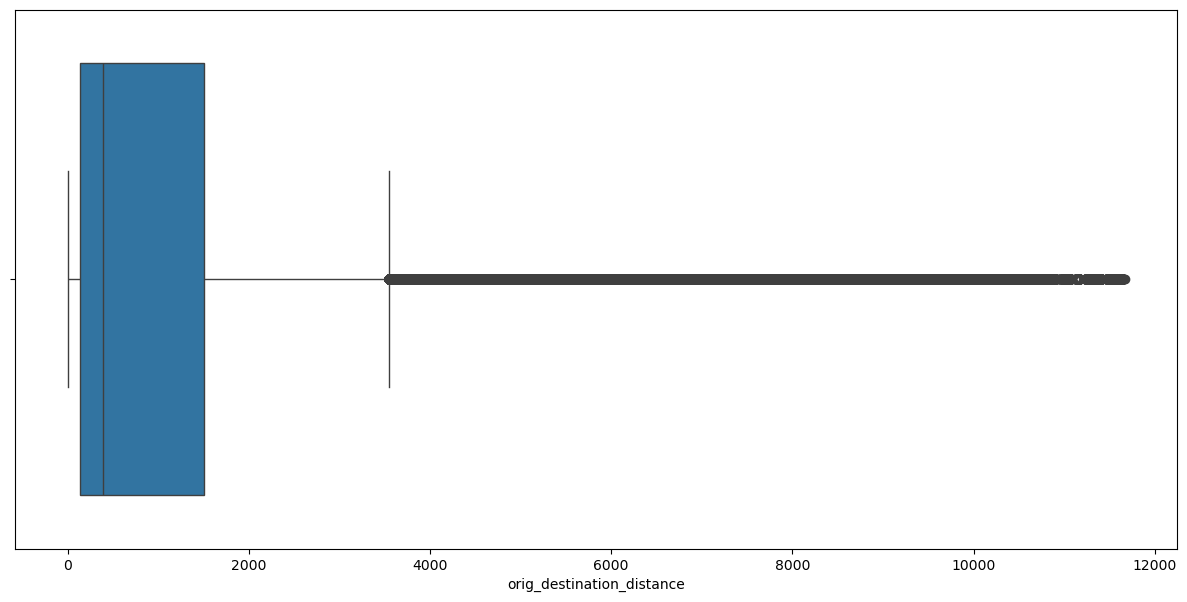

In [85]:
# location_scores = df.loc[:,['prop_location_score1', 'prop_location_score2']]
# print(location_scores)
print(df['orig_destination_distance'].sample(50))
plt.figure(figsize=(15, 7))
# sns.histplot(df['orig_destination_distance'], bins=100, kde=True)
sns.boxplot(x=df['orig_destination_distance'])

--- Distribution of click_bool ---


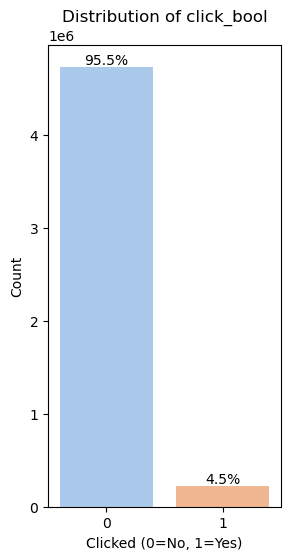

click_bool
0    0.955251
1    0.044749
Name: proportion, dtype: float64
--------------------------------------------------


In [86]:
print("--- Distribution of click_bool ---")
plt.figure(figsize=(3, 6))
sns.countplot(x='click_bool',hue='click_bool', data=df, palette="pastel",legend=False)
plt.title('Distribution of click_bool')
plt.xlabel('Clicked (0=No, 1=Yes)')
plt.ylabel('Count')
# Annotate with percentages
total_clicks = len(df['click_bool'])
if total_clicks > 0: # Avoid division by zero if dataframe is empty
    for p in plt.gca().patches:
        percentage = f'{100 * p.get_height() / total_clicks:.1f}%'
        x_ann = p.get_x() + p.get_width() / 2
        y_ann = p.get_height()
        plt.gca().annotate(percentage, (x_ann, y_ann), ha='center', va='bottom')
plt.show()
print(df['click_bool'].value_counts(normalize=True))
print("-" * 50)

--- Distribution of booking_bool ---


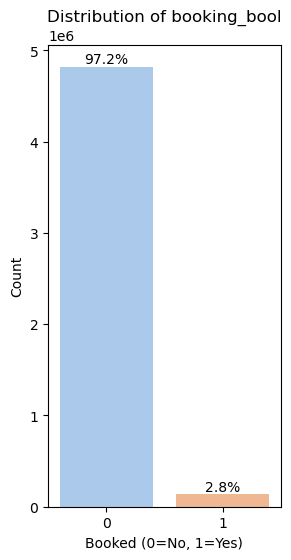

booking_bool
0    0.972089
1    0.027911
Name: proportion, dtype: float64
--------------------------------------------------


In [87]:
print("--- Distribution of booking_bool ---")
plt.figure(figsize=(3, 6))
sns.countplot(x='booking_bool',hue='booking_bool', data=df, palette="pastel",legend=False)
plt.title('Distribution of booking_bool')
plt.xlabel('Booked (0=No, 1=Yes)')
plt.ylabel('Count')
# Annotate with percentages
total_bookings = len(df['booking_bool'])
if total_bookings > 0: # Avoid division by zero if dataframe is empty
    for p in plt.gca().patches:
        percentage = f'{100 * p.get_height() / total_bookings:.1f}%'
        x_ann = p.get_x() + p.get_width() / 2
        y_ann = p.get_height()
        plt.gca().annotate(percentage, (x_ann, y_ann), ha='center', va='bottom')
plt.show()
print(df['booking_bool'].value_counts(normalize=True))
print("-" * 50)

Review scores filling
7364
0
--------------------------------------------------
location scores filling
0    0.0438
1    0.0149
2    0.0245
3    0.0125
4    0.1241
5    0.1302
6    0.0356
7       NaN
8    0.1238
9    0.1028
Name: prop_location_score2, dtype: float64


/var/folders/1m/wkv7c1qj5qv7hrgzg1vx89q40000gn/T/ipykernel_10298/2559145737.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['prop_review_score'].fillna(mean_review_value,inplace=True)


prop_country_id
1     0.06980
2     0.02600
4     0.01920
7     0.10175
9     0.05110
10    0.22250
11    0.02460
13    0.01130
14    0.03430
15    0.01370
Name: prop_location_score2, dtype: float64
0.019

Missing values in 'prop_location_score2' BEFORE imputation: 1090348
Missing values in 'prop_location_score2' AFTER imputation: 0
0    0.0438
1    0.0149
2    0.0245
3    0.0125
4    0.1241
5    0.1302
6    0.0356
7    0.0182
8    0.1238
9    0.1028
Name: prop_location_score2, dtype: float64


/var/folders/1m/wkv7c1qj5qv7hrgzg1vx89q40000gn/T/ipykernel_10298/2559145737.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['prop_location_score2'].fillna(global_q1_fallback_loc2, inplace=True)


<Axes: xlabel='prop_location_score2', ylabel='Count'>

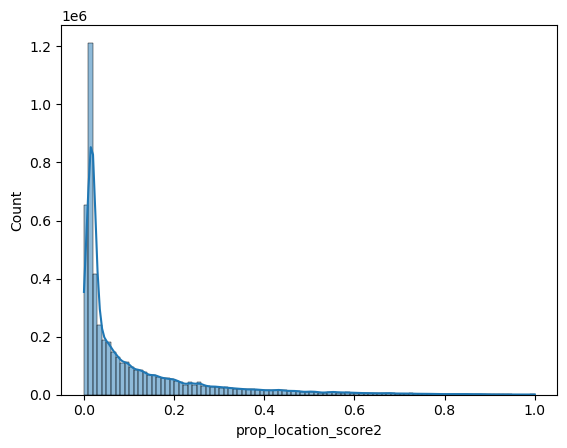

In [88]:
#Imputing values
#prop_review_score
print("Review scores filling")
mean_review_value = df['prop_review_score'].mean()
print(df['prop_review_score'].isna().sum())
df['prop_review_score'].fillna(mean_review_value,inplace=True)
print(df['prop_review_score'].isna().sum())



#prop_location_score2
print(50*'-')
print("location scores filling")
print(df['prop_location_score2'].head(10))
country_q1_map = df.groupby('prop_country_id')['prop_location_score2'].quantile(0.25)
global_q1_fallback_loc2 = df['prop_location_score2'].quantile(0.25)
print(country_q1_map.head(10))
print(global_q1_fallback_loc2)
nans_before_imputation = df['prop_location_score2'].isnull().sum()
print(f"\nMissing values in 'prop_location_score2' BEFORE imputation: {nans_before_imputation}")

imputation_values_for_nan_rows = df.loc[df['prop_location_score2'].isnull(), 'prop_country_id'].map(country_q1_map)
df.loc[df['prop_location_score2'].isnull(), 'prop_location_score2'] = imputation_values_for_nan_rows
df['prop_location_score2'].fillna(global_q1_fallback_loc2, inplace=True)

nans_after_imputation = df['prop_location_score2'].isnull().sum()
print(f"Missing values in 'prop_location_score2' AFTER imputation: {nans_after_imputation}")
print(df['prop_location_score2'].head(10))
sns.histplot(df['prop_location_score2'], bins=100, kde=True)




--------------------------------------------------
location scores filling
Distance to the property values filling
4958297         NaN
4958298         NaN
4958299         NaN
4958300         NaN
4958301         NaN
4958302         NaN
4958303         NaN
4958304         NaN
4958305         NaN
4958306         NaN
4958307         NaN
4958308         NaN
4958309         NaN
4958310         NaN
4958311         NaN
4958312         NaN
4958313    5.798820
4958314    5.797000
4958315    5.799850
4958316    5.801756
4958317    5.799002
4958318    5.800576
4958319    5.801998
4958320    5.800213
4958321    5.800032
4958322    5.799426
4958323    5.798971
4958324    5.799274
4958325    5.799032
4958326    5.800122
4958327    5.799941
4958328    5.799668
4958329    5.797940
4958330    5.799153
4958331    5.799699
4958332    5.797212
4958333    5.800455
4958334    5.801635
4958335    5.798213
4958336    5.798790
4958337    5.798577
4958338    5.801151
4958339    5.798244
4958340    5.798881
49583

/var/folders/1m/wkv7c1qj5qv7hrgzg1vx89q40000gn/T/ipykernel_10298/868329756.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['log_orig_destination_distance'].fillna(median_log_distance,inplace=True)


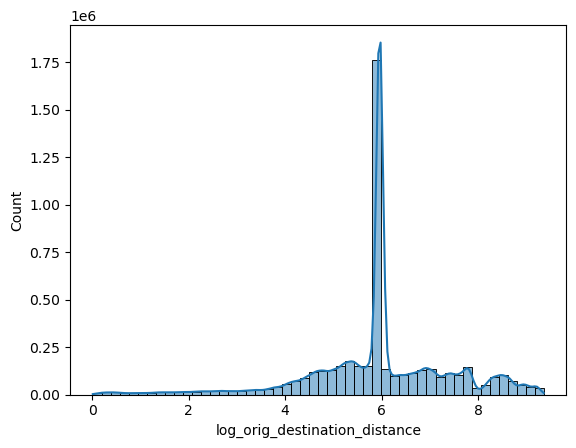

In [89]:
#orig_destination_distance
#later we will use log_orig_destination_distance and drop the original column
print(50*'-')
print("location scores filling")
print("Distance to the property values filling")
df['log_orig_destination_distance'] = np.log1p(df['orig_destination_distance'])
print(df['log_orig_destination_distance'].tail(50))
median_log_distance = df['log_orig_destination_distance'].median()
df['distance_missing'] = df['orig_destination_distance'].isna().astype(int)
df['log_orig_destination_distance'].fillna(median_log_distance,inplace=True)
print(50*'-')
print(df['log_orig_destination_distance'].isna().sum())    
# df['log_orig_destination_distance'].plot(kind='hist', bins=100, figsize=(15, 7), color='purple')
sns.histplot(df['log_orig_destination_distance'], bins=50, kde=True)
df = df.drop(columns=['orig_destination_distance'])

Number of zero prices: 31
1st percentile of positive prices: 34.00
Replaced 31 zero price_usd values with 34.00
99th percentile (upper cap limit) for price_usd: 770.00
Number of price_usd values above 770.00: 24760
Capped 24760 high outliers to 770.00

1st percentile (lower cap limit) for price_usd: 34.00
Number of price_usd values below 34.00: 49400
Capped 49400 low outliers to 34.00


<Axes: xlabel='price_usd', ylabel='Count'>

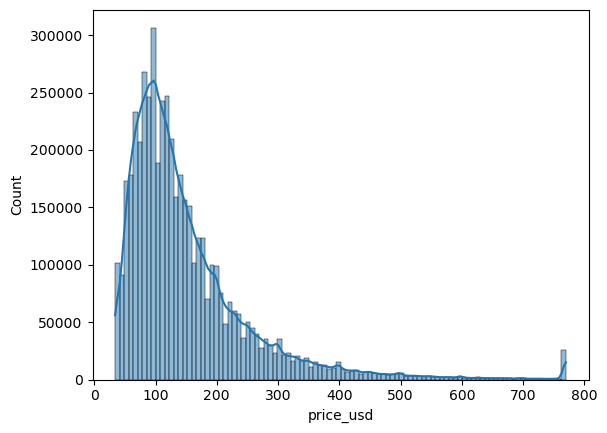

In [90]:
#Price_usd fixing values 
zero_price_count = (df['price_usd'] == 0).sum()
print(f"Number of zero prices: {zero_price_count}")
positive_prices = df.loc[(df['price_usd'] > 0) & (df['price_usd'].notna()), 'price_usd']
low_percentile_price = positive_prices.quantile(0.01) # 1st percentile
print(f"1st percentile of positive prices: {low_percentile_price:.2f}")
        
# Replace 0s with this low percentile value
df.loc[df['price_usd'] == 0, 'price_usd'] = low_percentile_price
print(f"Replaced {zero_price_count} zero price_usd values with {low_percentile_price:.2f}")

#Replace extreme outliers with the 99.5th percentile value
upper_cap_limit = df['price_usd'].quantile(0.995)
print(f"99th percentile (upper cap limit) for price_usd: {upper_cap_limit:.2f}")
# Identify values above the cap
outliers_above_cap = (df['price_usd'] > upper_cap_limit).sum()
print(f"Number of price_usd values above {upper_cap_limit:.2f}: {outliers_above_cap}")

if outliers_above_cap > 0:
        # Cap the values: set any price_usd greater than upper_cap_limit to upper_cap_limit
        df.loc[df['price_usd'] > upper_cap_limit, 'price_usd'] = upper_cap_limit
        print(f"Capped {outliers_above_cap} high outliers to {upper_cap_limit:.2f}")
else:
        print("No high outliers found above the 99th percentile to cap.")

#Replace low extreme outliers with the 1st percentile value

lower_cap_limit_low = df['price_usd'].quantile(0.01) 
print(f"\n1st percentile (lower cap limit) for price_usd: {lower_cap_limit_low:.2f}")

outliers_below_cap_low = (df['price_usd'] < lower_cap_limit_low).sum()
print(f"Number of price_usd values below {lower_cap_limit_low:.2f}: {outliers_below_cap_low}")
if outliers_below_cap_low > 0:
        # Cap the values
        df.loc[df['price_usd'] < lower_cap_limit_low, 'price_usd'] = lower_cap_limit_low
        print(f"Capped {outliers_below_cap_low} low outliers to {lower_cap_limit_low:.2f}")
else:
        print("No low outliers found below the 1st percentile to cap.")


sns.histplot(df['price_usd'], bins=100, kde=True)




Number of entries with visitor history (ADR): 252988
count    4.958347e+06
mean     1.243824e+00
std      3.070277e+01
min     -7.319200e+02
1%      -5.014540e+01
5%       0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
95%      0.000000e+00
99%      1.009500e+02
max      1.903700e+03
Name: price_diff, dtype: float64


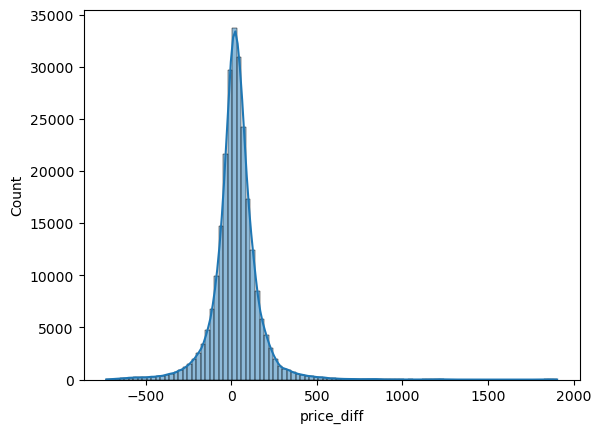

In [91]:
#visitor history missing values 
df['visitor_history_present'] = df['visitor_hist_adr_usd'].notna().astype(int)
print(f"Number of entries with visitor history (ADR): {df['visitor_history_present'].sum()}")

#Engineer the new feature
df['price_diff'] = 0.0


condition_history_present = df['visitor_hist_adr_usd'].notna()
df.loc[condition_history_present, 'price_diff'] = df.loc[condition_history_present, 'visitor_hist_adr_usd'] - df.loc[condition_history_present, 'price_usd']

print(df['price_diff'].describe(percentiles=[.01, .05, .25, .5, .75, .95, .99]))
price_diff_with_history = df.loc[df['visitor_history_present'] == 1, 'price_diff']
sns.histplot(price_diff_with_history, bins=100, kde=True)
df = df.drop(columns=['visitor_hist_adr_usd'])



251866
count    4.958347e+06
mean     6.535045e-03
std      2.473690e-01
min     -3.500000e+00
1%      -7.500000e-01
5%       0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
95%      0.000000e+00
99%      1.000000e+00
max      5.000000e+00
Name: starrating_diff, dtype: float64


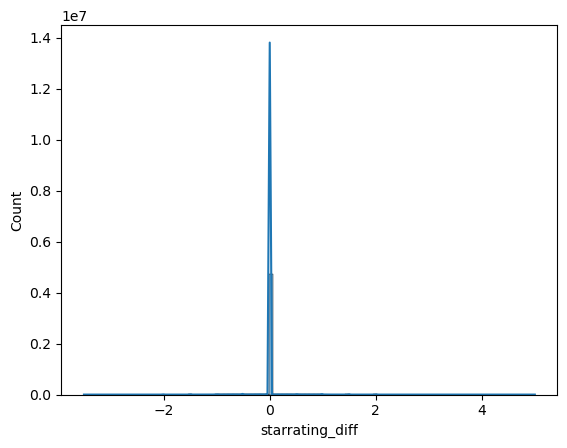

In [92]:
#Starrating history missing values and feature engineering
df['visitor_starrating_hist_present'] = df['visitor_hist_starrating'].notna().astype(int)
print(df['visitor_starrating_hist_present'].sum())

df['starrating_diff'] =0.0
condition_star_history_present = df['visitor_hist_starrating'].notna() 

df.loc[condition_star_history_present, 'starrating_diff'] = \
    df.loc[condition_star_history_present, 'visitor_hist_starrating'] - df.loc[condition_star_history_present, 'prop_starrating']

print(df['starrating_diff'].describe(percentiles=[.01, .05, .25, .5, .75, .95, .99]))   
sns.histplot(df['starrating_diff'], bins=100, kde=True)
df = df.drop(columns=['visitor_hist_starrating'])


In [93]:
df = df.drop(columns=['srch_query_affinity_score'])
print(df.isna().sum())

srch_id                                  0
site_id                                  0
visitor_location_country_id              0
prop_country_id                          0
prop_id                                  0
prop_starrating                          0
prop_review_score                        0
prop_brand_bool                          0
prop_location_score1                     0
prop_location_score2                     0
prop_log_historical_price                0
position                                 0
price_usd                                0
promotion_flag                           0
srch_destination_id                      0
srch_length_of_stay                      0
srch_booking_window                      0
srch_adults_count                        0
srch_children_count                      0
srch_room_count                          0
srch_saturday_night_bool                 0
random_bool                              0
comp1_rate                         4838417
comp1_inv  

In [94]:
#check for competition and feature engineering
comp_rate_cols = [f'comp{i}_rate' for i in range(1, 9)]
comp_inv_cols = [f'comp{i}_inv' for i in range(1, 9)]
df['expedia_price_competitiveness'] = 0

#check for any cheaper alternative
is_any_comp_cheaper = (df[comp_rate_cols] == -1).any(axis=1)
df.loc[is_any_comp_cheaper, 'expedia_price_competitiveness'] = -1



#check for expedia advantage
is_any_comp_better_deal_for_expedia = (df[comp_rate_cols] == 1).any(axis=1)


condition_for_positive_competitiveness = (df['expedia_price_competitiveness'] == 0) & is_any_comp_better_deal_for_expedia
df.loc[condition_for_positive_competitiveness, 'expedia_price_competitiveness'] = 1

print("Engineered 'expedia_price_competitiveness'. Values:")
print(df['expedia_price_competitiveness'].value_counts(dropna=False))


#Sole availability check 
df['expedia_has_sole_availability_among_known_comps'] = 0

# To implement "all non-NaN compX_inv values are +1":
# We need to check two things for each row:
#   a) There is at least one non-NaN comp_inv value (i.e., we have some inventory data for competitors)
#   b) Among those non-NaN values, none of them are 0 (i.e., no competitor also has availability)
#      (This implicitly means all non-NaN values must be +1, as +1 is the only other non-NaN option besides 0)

# Create boolean Series for these conditions
has_any_comp_inv_data = df[comp_inv_cols].notna().any(axis=1)
is_any_comp_also_available = (df[comp_inv_cols] == 0).any(axis=1)

# Expedia has sole availability if:
# - There IS competitor inventory data AND
# - NO competitor (with data) also has availability (i.e., all known competitor inv statuses are +1)
condition_sole_availability = has_any_comp_inv_data & (~is_any_comp_also_available)
df.loc[condition_sole_availability, 'expedia_has_sole_availability_among_known_comps'] = 1


print("Engineered 'expedia_has_sole_availability_among_known_comps'. Values:")
print(df['expedia_has_sole_availability_among_known_comps'].value_counts(dropna=False))

df['total_fee'] = df['price_usd']*df['srch_room_count']

#Dropping original columns
comp_rate_cols = [f'comp{i}_rate' for i in range(1, 9)]
comp_inv_cols = [f'comp{i}_inv' for i in range(1, 9)]
comp_diff_cols = [f'comp{i}_rate_percent_diff' for i in range(1, 9)]

columns_to_drop = comp_rate_cols + comp_inv_cols + comp_diff_cols
df.drop(columns=columns_to_drop, inplace=True, errors='ignore')
print(df.columns.tolist())

print(df.isna().sum())
print(50*'-')
print(df.shape)
print(50*'-')
print(df.info())




Engineered 'expedia_price_competitiveness'. Values:
expedia_price_competitiveness
 0    3690225
 1     680296
-1     587826
Name: count, dtype: int64
Engineered 'expedia_has_sole_availability_among_known_comps'. Values:
expedia_has_sole_availability_among_known_comps
0    4840767
1     117580
Name: count, dtype: int64
['srch_id', 'site_id', 'visitor_location_country_id', 'prop_country_id', 'prop_id', 'prop_starrating', 'prop_review_score', 'prop_brand_bool', 'prop_location_score1', 'prop_location_score2', 'prop_log_historical_price', 'position', 'price_usd', 'promotion_flag', 'srch_destination_id', 'srch_length_of_stay', 'srch_booking_window', 'srch_adults_count', 'srch_children_count', 'srch_room_count', 'srch_saturday_night_bool', 'random_bool', 'click_bool', 'booking_bool', 'search_month', 'log_orig_destination_distance', 'distance_missing', 'visitor_history_present', 'price_diff', 'visitor_starrating_hist_present', 'starrating_diff', 'expedia_price_competitiveness', 'expedia_has_so

--- Generating Feature-Feature Correlation Matrix Heatmap ---


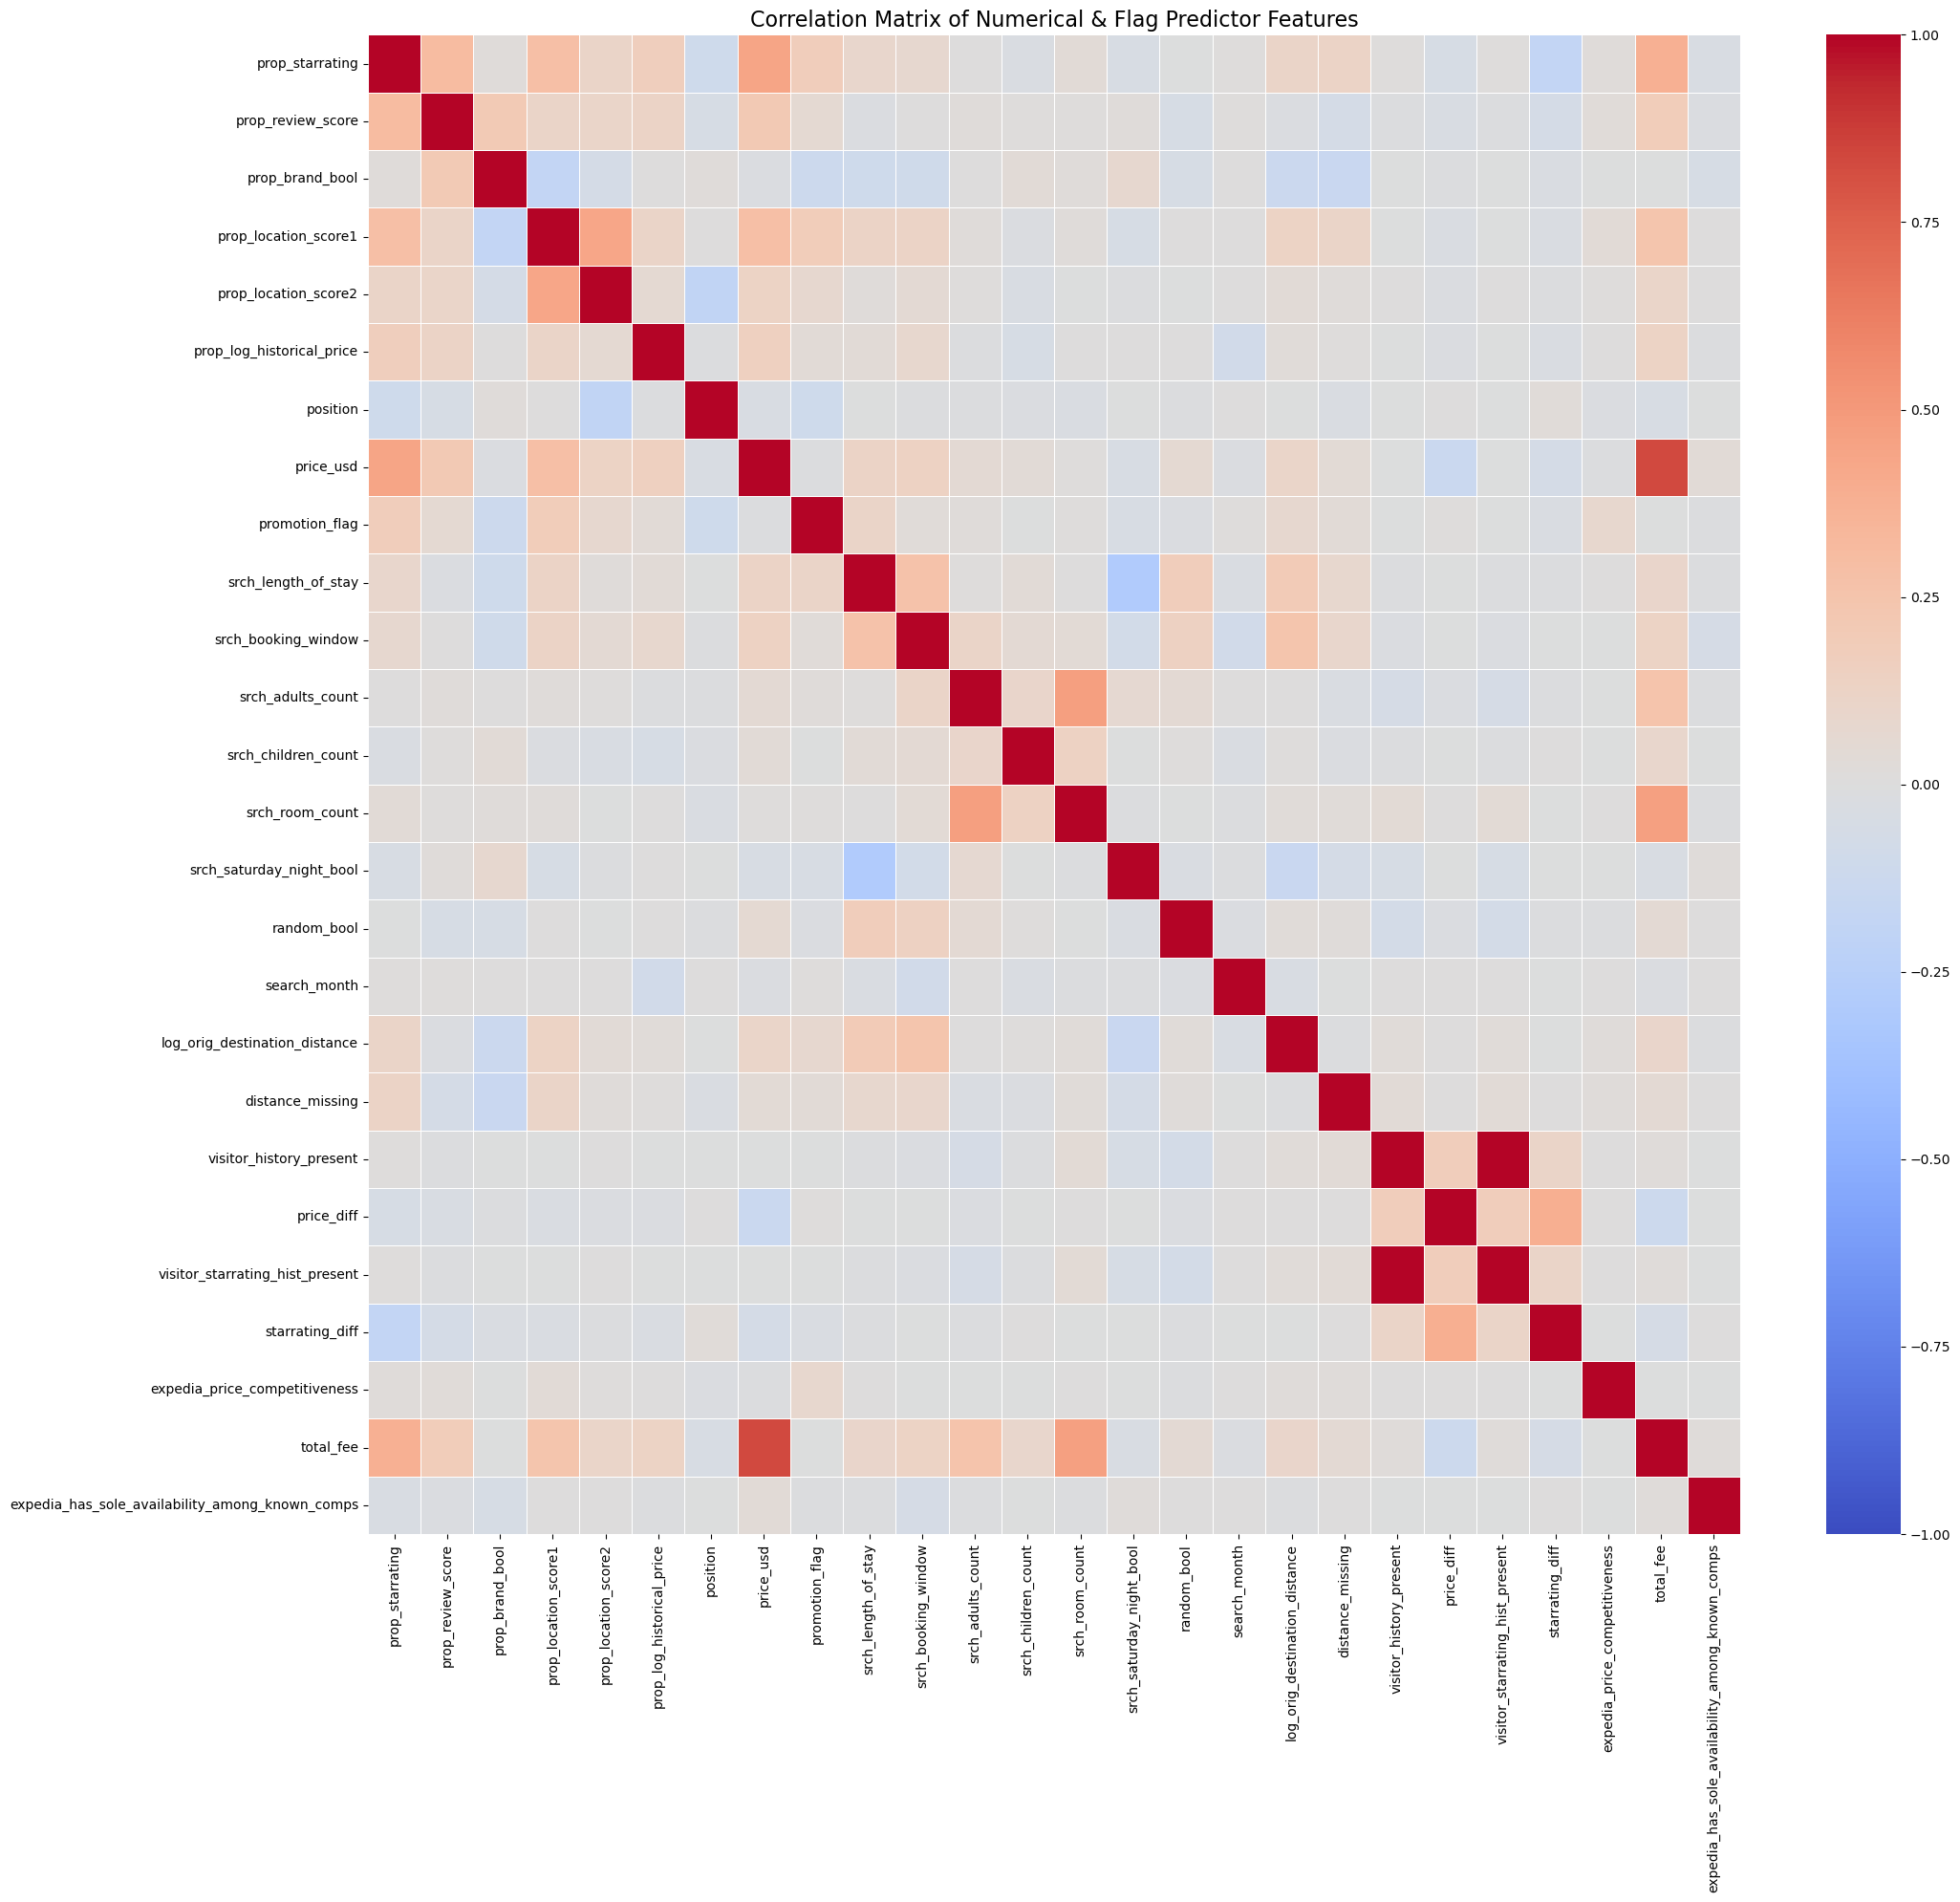


--- Generating Feature-Target Correlations ---

--- Correlation with click_bool ---
prop_location_score2                               0.081719
promotion_flag                                     0.039440
prop_starrating                                    0.030788
prop_review_score                                  0.023410
expedia_price_competitiveness                      0.016384
srch_room_count                                    0.007044
srch_children_count                                0.006012
random_bool                                        0.005819
distance_missing                                   0.005420
srch_adults_count                                  0.004620
expedia_has_sole_availability_among_known_comps    0.003567
prop_log_historical_price                          0.003360
price_diff                                         0.002834
srch_length_of_stay                                0.002647
prop_location_score1                               0.002184
srch_booking_wi

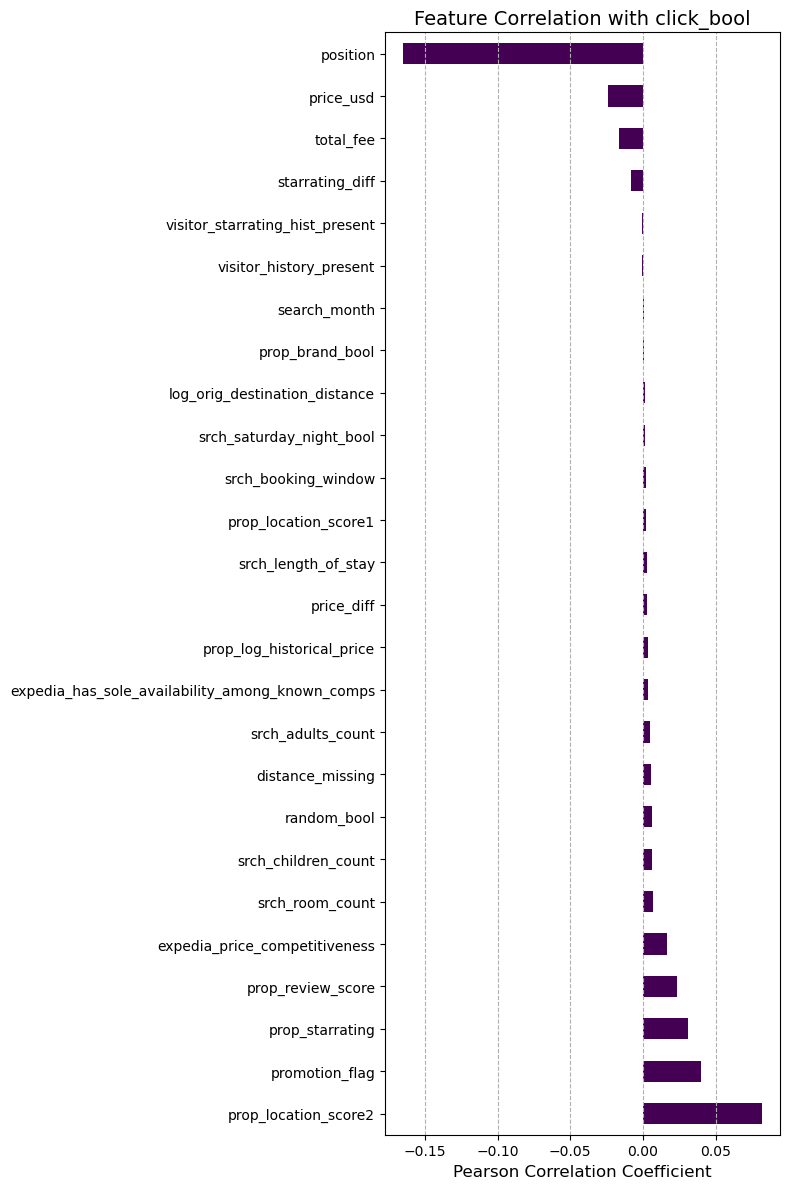


--- Correlation with booking_bool ---
prop_location_score2                               0.074133
promotion_flag                                     0.036047
prop_review_score                                  0.025789
prop_starrating                                    0.021206
expedia_price_competitiveness                      0.016531
visitor_history_present                            0.011535
visitor_starrating_hist_present                    0.011477
prop_brand_bool                                    0.009991
srch_room_count                                    0.007948
price_diff                                         0.006229
srch_saturday_night_bool                           0.005478
srch_children_count                                0.003872
expedia_has_sole_availability_among_known_comps    0.003350
search_month                                       0.001922
distance_missing                                  -0.000484
prop_log_historical_price                         -0.000807
p

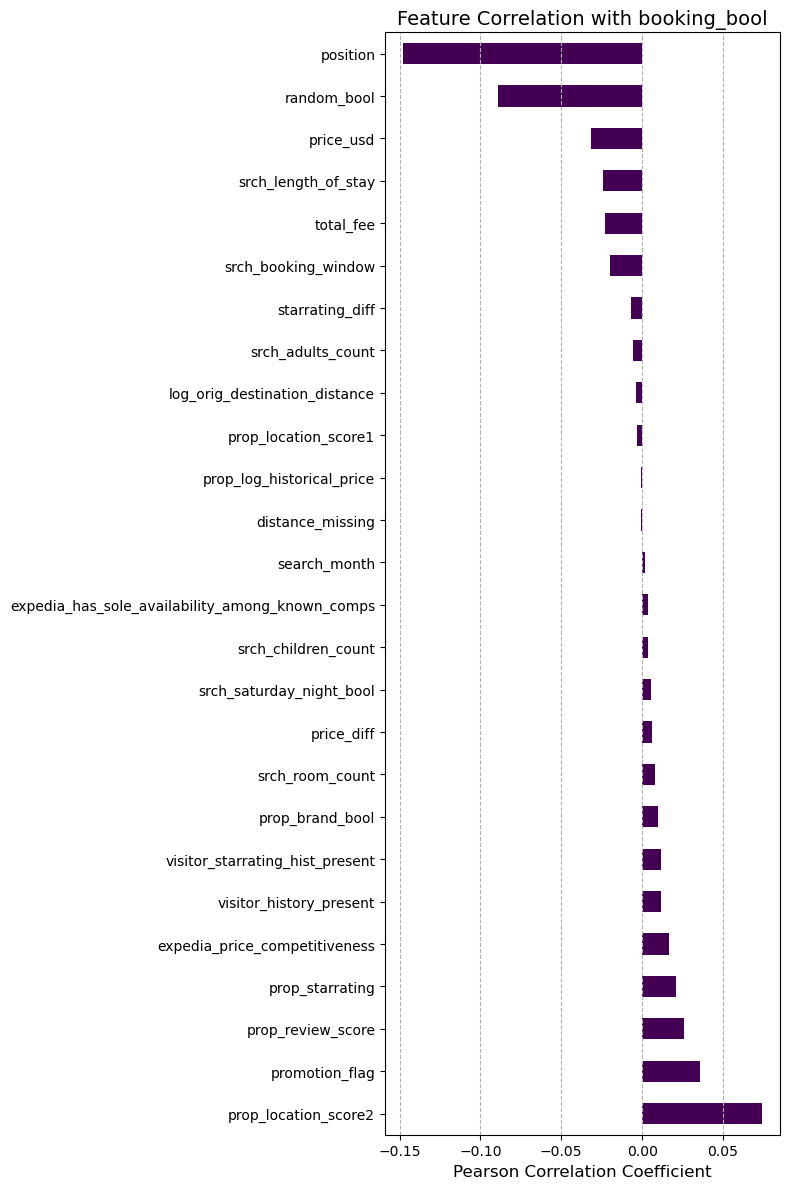

In [95]:
print("--- Generating Feature-Feature Correlation Matrix Heatmap ---")

# This list should include your continuous, binary (0/1), and ternary (-1/0/1) features
# that you want to examine for inter-correlations.
# It EXCLUDES pure ID columns and the target variables.
numerical_predictor_cols = [
    'prop_starrating', 'prop_review_score', 'prop_brand_bool',
    'prop_location_score1', 'prop_location_score2', 'prop_log_historical_price',
    'position', 'price_usd', # This is your cleaned price_usd
    'promotion_flag',
    'srch_length_of_stay', 'srch_booking_window', 'srch_adults_count',
    'srch_children_count', 'srch_room_count', 'srch_saturday_night_bool',
    'random_bool',
    'search_month',
    'log_orig_destination_distance', 'distance_missing',
    'visitor_history_present',
    'price_diff',
    'visitor_starrating_hist_present', # Assuming you created this or a similar combined one
    'starrating_diff',
    'expedia_price_competitiveness',
    'total_fee',
    'expedia_has_sole_availability_among_known_comps'
    # Add any other engineered numerical/flag features here
    # e.g., if you create total_stay_cost_all_rooms or total_nightly_cost_all_rooms
]

# Ensure all columns in the list actually exist in the DataFrame to avoid errors
existing_numerical_predictor_cols = [col for col in numerical_predictor_cols if col in df.columns]

if existing_numerical_predictor_cols:
    correlation_matrix = df[existing_numerical_predictor_cols].corr()

    plt.figure(figsize=(22, 20)) # Increased size for more features
    sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f", linewidths=.5, vmin=-1, vmax=1)
    # annot=False is good for many features. Set vmin/vmax for consistent color scaling.
    plt.title('Correlation Matrix of Numerical & Flag Predictor Features', fontsize=16)
    plt.xticks(fontsize=10, rotation=90) # Rotate for better readability if many features
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()
else:
    print("No numerical predictor columns identified for feature-feature correlation matrix.")


# --- 2. Correlation Between Features and Target Values ---
print("\n--- Generating Feature-Target Correlations ---")

targets = ['click_bool', 'booking_bool']

if existing_numerical_predictor_cols:
    for target in targets:
        if target in df.columns:
            # Create a temporary DataFrame with predictors and the current target
            df_for_corr = df[existing_numerical_predictor_cols + [target]].copy()
            target_correlations = df_for_corr.corr()[target].sort_values(ascending=False)

            print(f"\n--- Correlation with {target} ---")
            # Drop self-correlation and correlations that might be NaN if a column was all constant
            print(target_correlations.drop(target, errors='ignore').dropna()) 

            # Visualization
            plt.figure(figsize=(8, 12)) # Made taller for more features
            target_correlations.drop(target, errors='ignore').dropna().plot(kind='barh', colormap='viridis')
            plt.title(f'Feature Correlation with {target}', fontsize=14)
            plt.xlabel('Pearson Correlation Coefficient', fontsize=12)
            plt.grid(axis='x', linestyle='--')
            plt.tight_layout()
            plt.show()
        else:
            print(f"Target column '{target}' not found in DataFrame.")
else:
    print("No numerical predictor columns identified for target correlation.")

In [97]:

output_dir = '../data/modified/' # As per your screenshot
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

csv_output_path = os.path.join(output_dir, 'df_imputed_improved_train.csv')

try:
    df.to_csv(csv_output_path, index=False)
except Exception as e:
    print(f"Error saving DataFrame to CSV: {e}") 